#GFF plotter

##Helping hands

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb


##Imports

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib as plt
#plt.use('TkAgg') 

import operator

import pylab
pylab.show()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Definitions

In [77]:
fileUrl = "https://dl.dropboxusercontent.com/u/753166/jbrowse/gbrowse_repeats.gff3.Gypsy.gff3"

FULL_FIG_W , FULL_FIG_H  = 16, 8
CHROM_FIG_W, CHROM_FIG_H = FULL_FIG_W, 20

##Setup

###Figure sizes controller

In [78]:
class size_controller(object):
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
    def __enter__(self):
        self.o = rcParams['figure.figsize']
        rcParams['figure.figsize'] = self.w, self.h
        return None
    
    def __exit__(self, type, value, traceback):
        rcParams['figure.figsize'] = self.o

###Column type definition

In [79]:
col_type_int = np.int64
col_type_flo = np.float64
col_type_str = np.object
col_info =[
    [ "chromosome", col_type_str ], 
    [ "source"    , col_type_str ],
    [ "type"      , col_type_str ],
    [ "start"     , col_type_int ],
    [ "end"       , col_type_int ],
    [ "qual"      , col_type_int ],
    [ "strand"    , col_type_str ],
    [ "frame"     , col_type_str ],
    [ "info"      , col_type_str ],
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))
col_types


{'chromosome': object,
 'end': numpy.int64,
 'frame': object,
 'info': object,
 'qual': numpy.int64,
 'source': object,
 'start': numpy.int64,
 'strand': object,
 'type': object}

##Read GFF

###Parse INFO column

In [80]:
info_keys = set()

def filter_conv(fi):
    global info_keys
    vs = []
    for pair in fi.split(";"):
        kv = pair.split("=")
        info_keys.add(kv[0])
        
        if len(kv) == 2:
            #in case of key/value pairs
            vs.append(kv)
        else:
            #in case of flags such as INDEL
            vs.append([kv[0], True])
         
    x = dict(zip([x[0] for x in vs], [x[1] for x in vs]))
    #z = pd.Series(x)
    #print z
    return x

###Read GFF
http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

In [81]:
CONVERTERS = {
    'info': filter_conv
}
SKIP_ROWS = 3
NROWS     = None
#index_col=['chromosome', 'start'], usecols=col_names, 
gffData = pd.read_csv(fileUrl, header=None, names=col_names, dtype=col_types, nrows=NROWS, skiprows=SKIP_ROWS, converters=CONVERTERS, verbose=True, delimiter="\t", comment="#")
gffData.head()

Tokenization took: 1796.01 ms
Type conversion took: 931.58 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 583.56 ms
Type conversion took: 631.18 ms
Parser memory cleanup took: 0.04 ms
Tokenization took: 393.16 ms
Type conversion took: 664.61 ms
Parser memory cleanup took: 0.01 ms


chromosome        source           type     start       end  qual strand frame  \
0  SL2.50ch12  ITAG_repeats  repeat_region  67121143  67121326   580      -     .   
1  SL2.50ch12  ITAG_repeats  repeat_region  67108101  67108203   589      -     .   
2  SL2.50ch12  ITAG_repeats  repeat_region  67107057  67107149   609      -     .   
3  SL2.50ch12  ITAG_repeats  repeat_region  67105653  67105898   341      -     .   
4  SL2.50ch12  ITAG_repeats  repeat_region  67105543  67105602   240      -     .   

                                                info  
0  {'Target': 'LTR_PGSC0003DMS000002542_2160%2031...  
1  {'Target': 'LTR_PGSC0003DMS000001085_1372%2035...  
2  {'Target': 'LTR_PGSC0003DMS000001085_1372%2046...  
3  {'Target': 'LTR_PGSC0003DMS000000019_19%206616...  
4  {'Target': 'LTR_scaffold03032_723%201973%20203...

###Add length column

In [82]:
gffData['length'] = gffData['end'] - gffData['start']
gffData.head()

chromosome        source           type     start       end  qual strand frame  \
0  SL2.50ch12  ITAG_repeats  repeat_region  67121143  67121326   580      -     .   
1  SL2.50ch12  ITAG_repeats  repeat_region  67108101  67108203   589      -     .   
2  SL2.50ch12  ITAG_repeats  repeat_region  67107057  67107149   609      -     .   
3  SL2.50ch12  ITAG_repeats  repeat_region  67105653  67105898   341      -     .   
4  SL2.50ch12  ITAG_repeats  repeat_region  67105543  67105602   240      -     .   

                                                info  length  
0  {'Target': 'LTR_PGSC0003DMS000002542_2160%2031...     183  
1  {'Target': 'LTR_PGSC0003DMS000001085_1372%2035...     102  
2  {'Target': 'LTR_PGSC0003DMS000001085_1372%2046...      92  
3  {'Target': 'LTR_PGSC0003DMS000000019_19%206616...     245  
4  {'Target': 'LTR_scaffold03032_723%201973%20203...      59

###Split INFO column

In [83]:
info_keys = list(info_keys)
info_keys.sort()
info_keys


['ID', 'Name', 'Target', 'repeat_class', 'score']

In [84]:
def gen_val_extracter(info_keys_g):

    def val_extracter_l(info_row, **kwargs):
        vals       = [None] * len(info_keys_g)

        for k,v in info_row.items():
            if k in info_keys_g:
                vals[info_keys_g.index(k)] = v
            else:
                pass

        return vals

    return val_extracter_l
    
gffData[info_keys] = gffData['info'].apply(gen_val_extracter(info_keys), axis=1).apply(pd.Series, 1)
gffData.head()

chromosome        source           type     start       end  qual strand frame  \
0  SL2.50ch12  ITAG_repeats  repeat_region  67121143  67121326   580      -     .   
1  SL2.50ch12  ITAG_repeats  repeat_region  67108101  67108203   589      -     .   
2  SL2.50ch12  ITAG_repeats  repeat_region  67107057  67107149   609      -     .   
3  SL2.50ch12  ITAG_repeats  repeat_region  67105653  67105898   341      -     .   
4  SL2.50ch12  ITAG_repeats  repeat_region  67105543  67105602   240      -     .   

                                                info  length       ID  \
0  {'Target': 'LTR_PGSC0003DMS000002542_2160%2031...     183  6614999   
1  {'Target': 'LTR_PGSC0003DMS000001085_1372%2035...     102  6614987   
2  {'Target': 'LTR_PGSC0003DMS000001085_1372%2046...      92  6614984   
3  {'Target': 'LTR_PGSC0003DMS000000019_19%206616...     245  6614982   
4  {'Target': 'LTR_scaffold03032_723%201973%20203...      59  6614980   

                            Name  \
0  LTR_PGSC0003DMS000002542_2160   
1  LTR_PGSC0003DMS000001085_1372   
2  LTR_PGSC0003DMS000001085_1372   
3    LTR_PGSC0003DMS000000019_19   
4          LTR_scaffold03032_723   

                                            Target repeat_class score  
0  LTR_PGSC0003DMS000002542_2160%203196%203388%20+  LTR%2FGypsy   580  
1  LTR_PGSC0003DMS000001085_1372%203560%203661%20+  LTR%2FGypsy   589  
2  LTR_PGSC0003DMS000001085_1372%204699%204792%20+  LTR%2FGypsy   609  
3    LTR_PGSC0003DMS000000019_19%206616%206866%20+  LTR%2FGypsy   341  
4          LTR_scaffold03032_723%201973%202037%20+  LTR%2FGypsy   240

##Good part

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb

http://pandas.pydata.org/pandas-docs/dev/visualization.html

https://bespokeblog.wordpress.com/2011/07/11/basic-data-plotting-with-matplotlib-part-3-histograms/

http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week3/exploratory_graphs.ipynb

http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html

http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/

###Column types

In [85]:
gffData.dtypes

chromosome      object
source          object
type            object
start            int64
end              int64
qual             int64
strand          object
frame           object
info            object
length           int64
ID              object
Name            object
Target          object
repeat_class    object
score           object

###Global statistics

In [86]:
gffData.describe()

start              end           qual         length
count    176355.000000    176355.000000  176355.000000  176355.000000
mean   31897867.603051  31898868.764736    4621.508435    1001.161685
std      816749.003415    777797.934077    7962.155057    1445.242492
min           1.000000       161.000000     225.000000      10.000000
25%    16917515.500000  16918151.000000     534.000000     157.000000
50%    30310731.000000  30312101.000000    1616.000000     437.000000
75%    45811002.500000  45812080.000000    5277.500000    1259.000000
max    98447010.000000  98448739.000000  199163.000000   23666.000000

###List of chromosomes

In [87]:
chromosomes = np.unique(gffData['chromosome'].values)
chromosomes

array(['SL2.50ch00', 'SL2.50ch01', 'SL2.50ch02', 'SL2.50ch03',
       'SL2.50ch04', 'SL2.50ch05', 'SL2.50ch06', 'SL2.50ch07',
       'SL2.50ch08', 'SL2.50ch09', 'SL2.50ch10', 'SL2.50ch11', 'SL2.50ch12'], dtype=object)

###Quality distribution

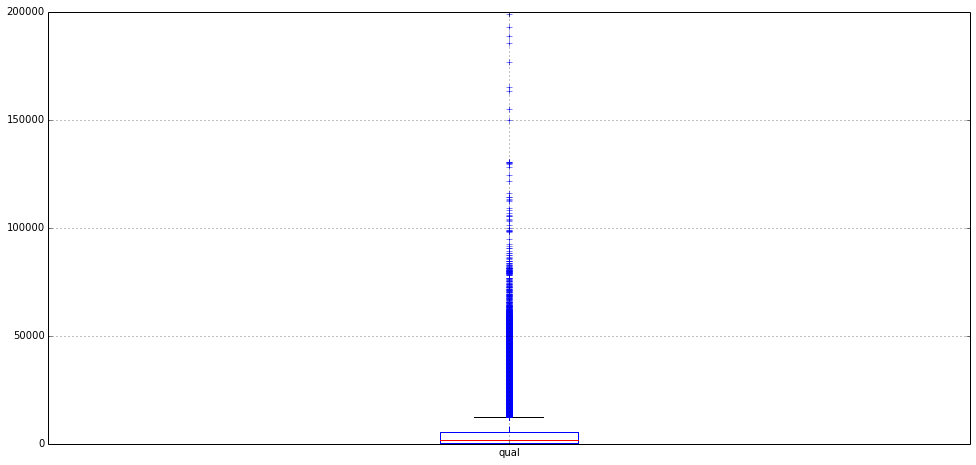

In [88]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bq = gffData.boxplot(column='qual')

###Quality distribution per chromosome

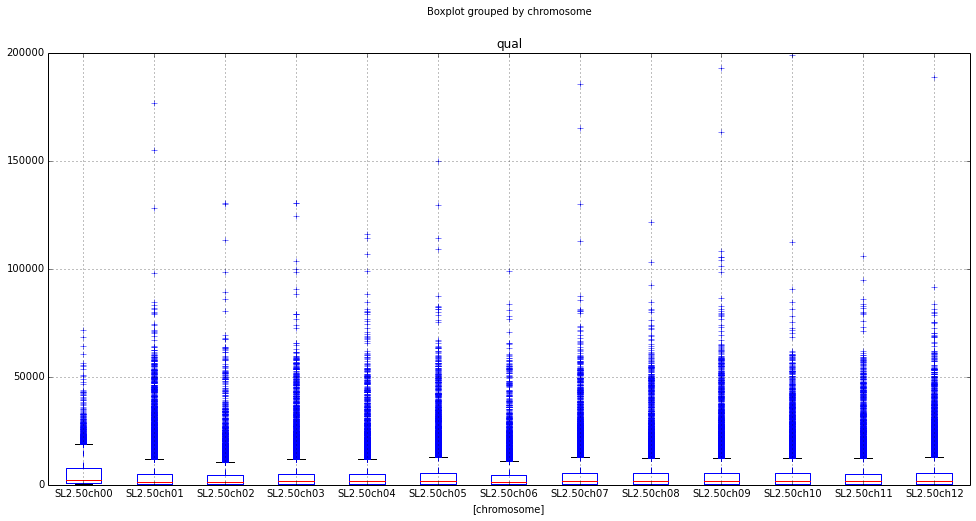

In [89]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bqc = gffData.boxplot(column='qual', by='chromosome')

###Position distribution

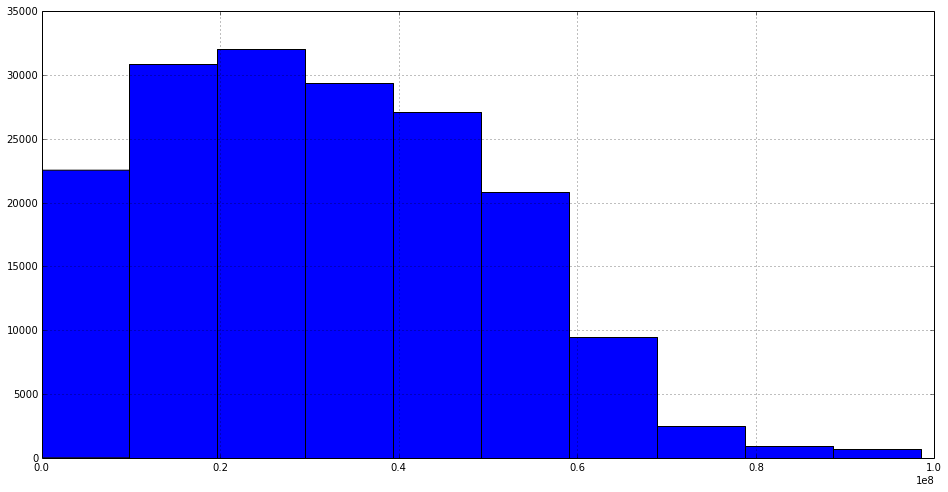

In [90]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hs = gffData['start'].hist()

###Position distribution per chromosome

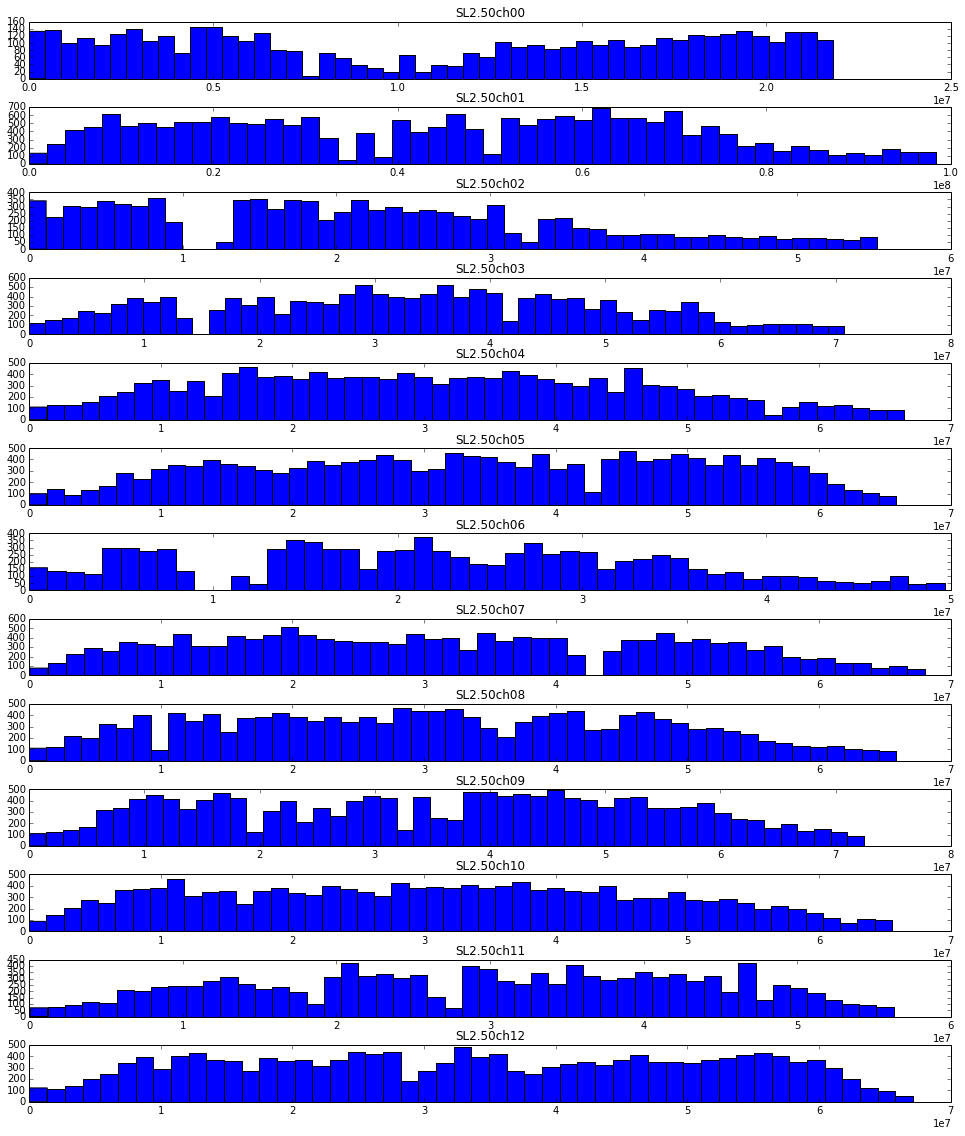

In [91]:
hsc = gffData['start'].hist(by=gffData['chromosome'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1)) 

###Length distribution

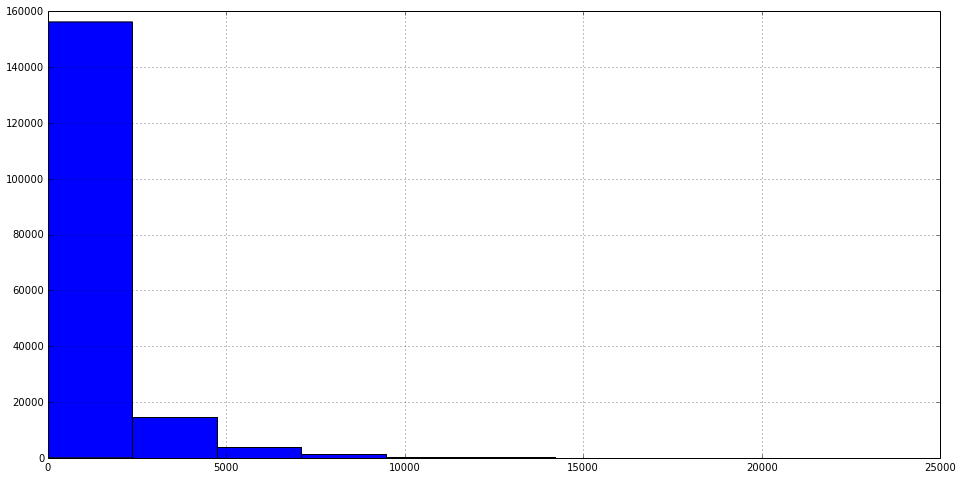

In [92]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hl = gffData['length'].hist()

###Length distribution per chromosome

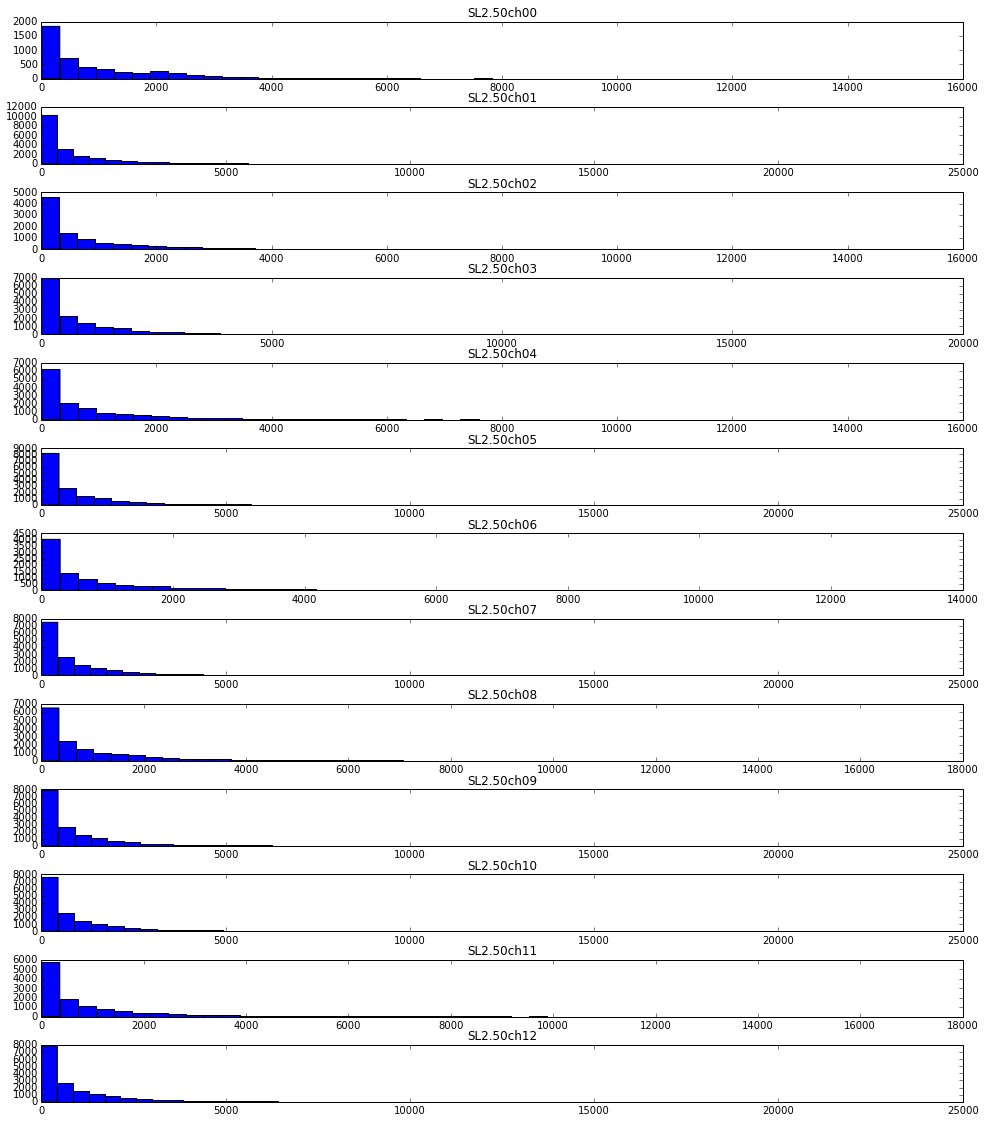

In [93]:
hlc = gffData['length'].hist(by=gffData['chromosome'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1))